In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib


import scipy
import numpy as np
import pandas
import sklearn

from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

from sklearn.model_selection import train_test_split

# Import data

## It is important to have:

1. Panda dataframe with column(s) you want to use for prediction and columns(s) you want to predict
2. Network (ppi) in case you want to use network propagation
3. Database of pathways

In [259]:
#mydata

###### RAW DATASET WITH ALL FEATURE

path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/disease_data_clear_6.tsv'
data_raw = pd.read_table(path, header = None, names = ['Entrez_ID', 'Genetic defect', 'Inheritance', 'T_cell_count', 'B_cell_count', 'Immunoglobulin_levels', 'Neutrophil_count', 'Other affected cells', 'Associated_features', 'GO_terms', 'Pathways', 'HPO_phenotype', 'Treatment', 'Treatment information', 'Nesto'])
del data_raw['Nesto']

##### JULIAS AUTOCORE DATASET
path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/drug_pathway_2.tsv'
drug_data = pd.read_table(path, header = None, names = ['EntrezID','Clinical_group', 'Treatment', 'Pathway', 'Nesto'])
del drug_data['Nesto']
drug_data = drug_data.replace('NaN_', np.nan)
drug_data = drug_data[drug_data['Treatment'].notna()]  #take only ones that have input
treatment_raw = drug_data['Treatment']

##### TREATMENT CLASSIFICATION
treatment_raw = drug_data['Treatment'].tolist()
treatment = []

for i in treatment_raw:
    treatment.extend(i.split(','))

treatment_nr = list(set(treatment)) #LIST OF TREATMENTS USED
treatment_freq = {}
treatment_nr.remove('')
treatment_nr.remove('na')

for i in treatment_nr:
    treatment_freq[i] = treatment.count (i)

treatment_freq = dict (sorted (treatment_freq.items(), key = lambda x:float(x[1]), reverse = True))
treatment_top = []  #only treatment used 10 or more times

# We use only drugs that occur 11 or more times in a data set
for i, j in treatment_freq.items():
    if j>11:
        treatment_top.append(i)

#drugs and list of proteins used
drugs_dict = {}  #{drug:list of EntrezIDs that can be cured by those}
for i in treatment_nr:
    lista = []
    for j, k in zip(list(drug_data['EntrezID']),list(drug_data['Treatment'])):
        if k.find(i) >= 0:
            lista.append(str(j))
    drugs_dict[i]=list(set(lista))
          

In [12]:
##### MONSTER NETWORK ###########

import networkx as nx

path = "/Users/Iva/Documents/project/data/databases/monster_ppi.txt"
data1 = open (path)
data_monster = []
data_monster_nr = []
data_monster_all = []

for i in data1:
    data_monster.append (i.split()[:2])
    data_monster_all.append(i.split())
    
for i in data_monster:
    data_monster_nr.append (i[0])
    data_monster_nr.append (i[1])
    
data_monster_nr = list(set(data_monster_nr))
G_monster = nx.Graph()
G_monster.add_edges_from(data_monster)

##### PATHWAYS
path = "/Users/Iva/Documents/project/data/msigdb_pathways.gmt.txt"
x = open (path)

data_dictionary = {}
l = []

for i in x:
    l.append (i.split())

data_dictionary = {item[0]:item[2:] for item in l} #working dictionary

In [ ]:
# JOEL MAGIC

def scaled_transition(G, nodes = None):
    if nodes == None:
        nodes = list(G.nodes())
    else:
        G = G.subgraph(nodes)

    A = nx.adjacency_matrix(G)
    temp = G.degree(weight = 'weight')
    degree = [temp[i] for i in nodes]
    scaling =  scipy.sparse.diags([1/i if i!=0 else 0 for i in degree])
    scaled = scaling * A
    return scaled



In [ ]:
#JOEL -original code 

import scipy.sparse
pathway_df = pd.DataFrame({i:{j:1 for j in v} for i,v in data_dictionary.items()})
pathway_df = pathway_df.fillna(0)
pathway_df = pathway_df.loc[list(set(G_monster.nodes()) & set(pathway_df.index))]
G_monster_path = G_monster.subgraph(set(pathway_df.index))
A = nx.adjacency_matrix(G_monster_path)

nodelist = pathway_df.index
rw_matrix = scaled_transition(G_monster_path, nodes=list(nodelist))
I = scipy.sparse.eye(len(nodelist))

restart = 0.99
many_step_rw = restart * (I + (1-restart)*rw_matrix + (1-restart)**2 * rw_matrix**2)
# + (1-restart)**3 * rw_matrix**3)

propagated = many_step_rw * pathway_df.iloc[:,]
propagated = pd.DataFrame(propagated)
propagated.columns = pathway_df.iloc[:,].columns
propagated.index = nodelist
propagated = propagated.reindex(data["Entrez_ID"])
propagated.shape





# Predict drugs based on pathways - verification of models


3 ways:
1. Pathways (Text based)
2. Pathways (non propagated)
3. Pathways (propagated on ppi network)


## 1. Text based machine learning

Splits words of pathway name, f.e. REACTOME ACTIN PATHWAY - 'REACTOME', 'ACTIN', 'PATHWAY'

In [430]:
### DRUG PREDICTION BASED ON PATHWAYS - TEXT BASED
path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/disease_data_clear_6.tsv'
data_raw = pd.read_table(path, header = None, names = ['Entrez_ID', 'Genetic defect', 'Inheritance', 'T_cell_count', 'B_cell_count', 'Immunoglobulin_levels', 'Neutrophil_count', 'Other affected cells', 'Associated_features', 'GO_terms', 'Pathways', 'HPO_phenotype', 'Treatment', 'Treatment information', 'Nesto'])
drug_data=data_raw


#path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/drug_pathway_2.tsv'
#drug_data = pd.read_table(path, header = None, names = ['EntrezID','Clinical_group', 'Treatment', 'Pathway', 'Nesto'])
del drug_data['Nesto']
data = drug_data
data = data.replace('NaN_', np.nan)
data = data[data['Treatment'].notna()]
drug_data=data

results_text = {}
results_text_acc ={}
results_text_f1 ={}
treatment_top # all drugs we are interested in

for d in treatment_top:
    drug_num = []
    name = str(d)
    for i in drug_data['Treatment']:
        if i.find(name) >= 0:
            drug_num.append(1)
        if i.find(name) < 0:
            drug_num.append(0)
     
    X = drug_data.Pathways #### CHOOSE PREDICTOR!! (drug_data.columnname, f.e. drug_data.Pathways)
    y = pd.Series(drug_num)

    ## devide into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = True)
    
    vect = CountVectorizer()
    X_train_dtm = vect.fit_transform(X_train.values.astype('U')) ## to account for nan
    X_test_dtm = vect.transform(X_test.values.astype('U')) ## to account for nan

    from sklearn.naive_bayes import MultinomialNB
    nb = MultinomialNB()  ## model
    
    
    ## train the model
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm) ###important to have same n of columns
    from sklearn import metrics
    results_text[name]=metrics.accuracy_score(y_test, y_pred_class)
    results_text_acc [name] = metrics.accuracy_score(y_test, y_pred_class)
    results_text_f1 [name] = metrics.f1_score(y_test, y_pred_class)
    '''print ('Drug name:', name)
    print ('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    print (metrics.confusion_matrix(y_test, y_pred_class))
    print ()'''
    


In [443]:
'''print (X)
print (y)'''

'print (X)\nprint (y)'

## 2. Pathways as predictor for therapy (unpropagated)




In [496]:
#### PATHWAYS (WITHOUT PROPAGATION AS) PREDICTOR OF THERAPY 

#IMPORT DATA

import scipy.sparse
pathway_df_c = pd.DataFrame({i:{j:1 for j in v} for i,v in data_dictionary.items()})
# load drugs - control
path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/drug_pathway_2.tsv'
drug_data = pd.read_table(path, header = None, names = ['EntrezID','Clinical_group', 'Treatment', 'Pathway', 'Nesto'])
del drug_data['Nesto']


a = list(drug_data['EntrezID'])
new = [str(i) for i in a]
b = list(pathway_df_c.index)
c = [i for i in new if i not in b]

for i in list(set(c)): #add all proteins we are interested in that are not in pathway database
    pathway_df_c = pathway_df_c.append(pandas.Series(name=i, dtype = 'object'))
    
pathway_df_c = pathway_df_c.fillna(0)
pathway_df_c = pathway_df_c.loc[list(set(G_monster.nodes()) & set(pathway_df.index))]
unpropagated_all = pathway_df_c

a = list(drug_data['EntrezID'])
a = [str(i) for i in a]

pathway_df_c = pathway_df_c.loc[a]  #only those rows that contain information on drugs

drug_data = drug_data.replace('NaN_', np.nan)
drug_data = drug_data[drug_data['Treatment'].notna()]  #take only ones that have input



In [491]:
#unpropagated_all

In [490]:
#ML

results_unpropagated_acc = {}
results_unpropagated_f1 = {}
results_unpropagated_auc = {}

for d in treatment_top:
    drug_num = []
    name = str(d)
    for i in drug_data['Treatment']:
        if i.find(name) >= 0:
            drug_num.append(1)
        if i.find(name) < 0:
            drug_num.append(0)

    #pathway_df_c[name] = drug_num

    X = pathway_df_c
    y = pd.Series(drug_num)

    #MULTINOMIAL NAIVE BAYESIAN
    from sklearn.naive_bayes import MultinomialNB
    nb = MultinomialNB()  ## model
    ## devide into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = True)
    
    #RANDOM FOREST
    '''pca = sklearn.decomposition.PCA(n_components=100)
    X_red = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, random_state = True)
    from sklearn.ensemble import RandomForestClassifier
    nb = RandomForestClassifier()'''
    
    ## train the model
    nb.fit(X_train, y_train)
    y_pred_class = nb.predict(X_test) ###important to have same n of columns

    from sklearn import metrics
    results_unpropagated_acc [name] = metrics.accuracy_score(y_test, y_pred_class)
    results_unpropagated_f1 [name] = metrics.f1_score(y_test, y_pred_class)
    #results_unpropagated_auc [name] = metrics.auc(y_test, y_pred_class)
    '''
    print ('Drug name:', name)
    print ('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    print (metrics.confusion_matrix(y_test, y_pred_class))
    
    print ('F score', metrics.f1_score(y_test, y_pred_class))
    print ()'''



In [489]:
#pathway_df_c

## 3. Propagation of pathways on a G_monster network before prediction of therapy

In [381]:
### NETWORK PROPAGATION OF PATHWAYS TO PREDICT POSSIBLE DRUGS

restart = 0.95 #RESTART PROBABILITY

import scipy.sparse
pathway_df = pd.DataFrame({i:{j:1 for j in v} for i,v in data_dictionary.items()})
a = pathway_df
a = list(drug_data['EntrezID'])

new = [str(i) for i in a]
b = list(pathway_df.index)
c = [i for i in new if i not in b]

for i in list(set(c)): #add all proteins we are interested in that are not in pathway database
    pathway_df = pathway_df.append(pandas.Series(name=i, dtype = 'object'))
    
pathway_df = pathway_df.fillna(0)
pathway_df = pathway_df.loc[list(set(G_monster.nodes()) & set(pathway_df.index))]

G_monster_path = G_monster.subgraph(set(pathway_df.index))
A = nx.adjacency_matrix(G_monster_path)

nodelist = pathway_df.index
rw_matrix = scaled_transition(G_monster_path, nodes=list(nodelist))
I = scipy.sparse.eye(len(nodelist))

many_step_rw = restart * (I + (1-restart)*rw_matrix + (1-restart)**2 * rw_matrix**2)
propagated = many_step_rw * pathway_df.iloc[:,]
propagated = pd.DataFrame(propagated)
propagated.columns = pathway_df.iloc[:,].columns
propagated.index = nodelist
propagated_all = propagated

a = list(drug_data['EntrezID'])
a = [str(i) for i in a]
propagated = propagated.loc[a]

In [ ]:

#load drug_data
path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/drug_pathway_2.tsv'
drug_data = pd.read_table(path, header = None, names = ['EntrezID','Clinical_group', 'Treatment', 'Pathway', 'Nesto'])
del drug_data['Nesto']
drug_data = drug_data.replace('NaN_', np.nan)
drug_data = drug_data[drug_data['Treatment'].notna()]  #take only ones that have input

results_propagated_acc = {} #ACCURACY
results_propagated_f1 = {} #F1 SCORE
results_propagated_auc = {} #AREA UNDER CURVE

#Machine learning
for drug in treatment_top:  #list of drugs that occur more than 10 times in all dataset
    drug_num = []
    name = str(drug)
    for i in drug_data['Treatment']: #
        if i.find(name) >= 0:
            drug_num.append(1)
        if i.find(name) < 0:
            drug_num.append(0)

    #propagated[name] = drug_num
    
    X = propagated
    y = pd.Series(drug_num)
    
    #MultinomialNB()
    from sklearn.naive_bayes import MultinomialNB
    nb = MultinomialNB()  ## model
    ## divide into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = True)
    
    
    #Random Forest - uncomment this part 
    '''pca = sklearn.decomposition.PCA(n_components=100)
    X_red = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, random_state = True)
    
    from sklearn.ensemble import RandomForestClassifier
    nb = RandomForestClassifier()'''
    
    ## train the model
    nb.fit(X_train, y_train)
    y_pred_class = nb.predict(X_test) ###important to have same n of columns
    
    from sklearn import metrics
    results_propagated_acc [name] = metrics.accuracy_score(y_test, y_pred_class)
    results_propagated_f1 [name] = metrics.f1_score(y_test, y_pred_class)
    #results_propagated_auc [name] = metrics.auc(y_test, y_pred_class)
    '''
    print ('Drug name:', name)
    print ('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    print (metrics.confusion_matrix(y_test, y_pred_class))
    
    print ('F score', metrics.f1_score(y_test, y_pred_class))
    print ()'''




## VISUALIZE F scores and verify your model

In [498]:
#temp = pd.DataFrame({"Unpropagated":results_control_acc, "Propagated":results_propagated_acc})
temp = pd.DataFrame({"Unpropagated":results_unpropagated_f1, "Propagated":results_propagated_f1, "Text":results_text_f1})



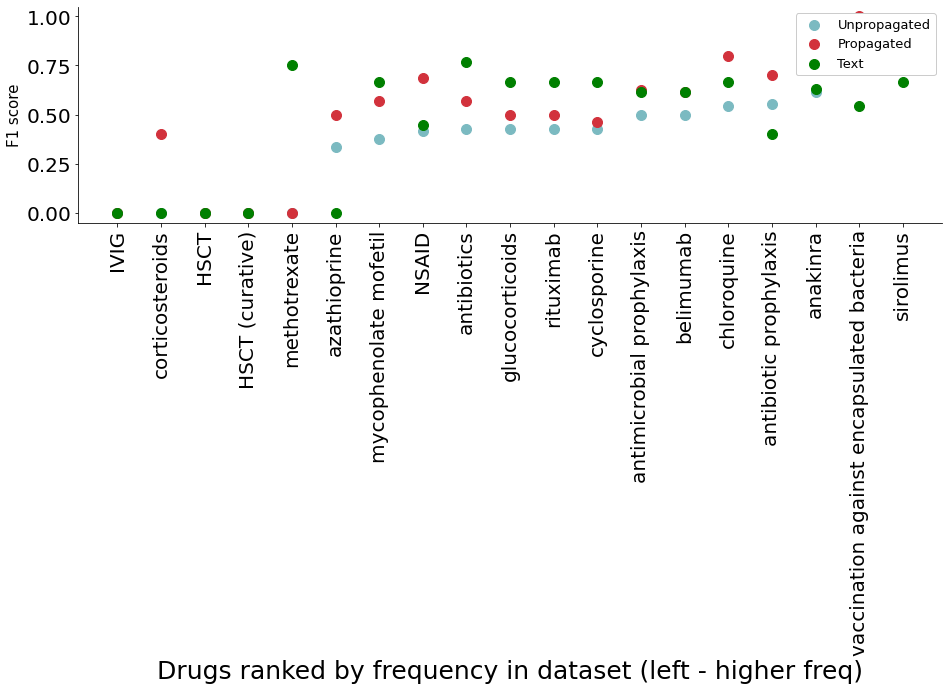

In [499]:
#VISUALISATION



fig = plt.figure(figsize = [12,3])
ax = fig.add_axes([0,0,1,1])

#temp = temp.loc[methods].transpose()
temp = temp.sort_values("Unpropagated")


colors = ['#7bbac1ff', '#d2323cff', 'green']
method_labels = ["Unpropagated", "Propagated", "Text"]
            
handles = []
for c,x in zip(colors,temp.columns):
    h = ax.scatter(range(len(temp.index)), temp[x], c=c, s = 100)
    handles.append(h)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([])
ax.set_xticks(range(19))
ax.set_xlabel("Drugs ranked by frequency in dataset (left - higher freq)", fontsize = 25)
ax.set_ylabel("F1 score", fontsize = 15)
if method_labels == None:
    method_labels = [i[0] for i in methods]
ax.legend(handles, method_labels, fontsize = 13, loc = 'upper right', framealpha = 1.0)
ax.xaxis.set_ticklabels(treatment_top, rotation = 90)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20 )



# Apply model to predict therapy for new genes of interest



In [457]:
#write list of EntrezIDs for genes that you want to see potential therapy

genelist = ['641', '355', '3071'] #genes must not be present in training dataset!!!


In [474]:
#load drug_data
path = '/Users/Iva/Documents/project/data/Machine_learning/final_data_set/drug_pathway_2.tsv'
drug_data = pd.read_table(path, header = None, names = ['EntrezID','Clinical_group', 'Treatment', 'Pathway', 'Nesto'])
del drug_data['Nesto']

drug_data = drug_data.replace('NaN_', np.nan)
drug_data = drug_data[drug_data['Treatment'].notna()]  #take only ones that have input

In [487]:


final_drugs=[]

#Machine learning

for gene in genelist:
    for d in treatment_top:
        drug_num = []
        name = str(d)
        for i in drug_data['Treatment']:
            if i.find(name) >= 0:
                drug_num.append(1)
            if i.find(name) < 0:
                drug_num.append(0)

        #propagated[name] = drug_num

        X = pathway_df_c
        y = pd.Series(drug_num)
        X_test = unpropagated_all.loc[gene].to_numpy()
        X_test = X_test.reshape(1, -1)

        from sklearn.naive_bayes import MultinomialNB
        nb = MultinomialNB()  ## model

        
        #from sklearn.ensemble import RandomForestClassifier
        #nb = RandomForestClassifier()
        #pca = sklearn.decomposition.PCA(n_components=100)
        #X_red = pca.fit_transform(X)

        ## train the model
        nb.fit(X, y)
        y_pred_class = nb.predict(X_test) ###important to have same n of columns
        from sklearn import metrics

        #print ('Drug name:', name)
        if y_pred_class == [1]:
            final_drugs.append(name)
        #print (y_pred_class)

    print ('Drugs that can be used for gene', gene, 'are:')
    print ()
    for i in set(final_drugs):
        print (i)
    print ()




Drugs that can be used for gene 641 are:

IVIG
antibiotics

Drugs that can be used for gene 355 are:

mycophenolate mofetil
antibiotics
corticosteroids
HSCT
IVIG
sirolimus

Drugs that can be used for gene 3071 are:

mycophenolate mofetil
HSCT (curative)
antibiotics
corticosteroids
HSCT
IVIG
sirolimus



# Leftover code

In [ ]:
pca = sklearn.decomposition.PCA(n_components=100)
X_red = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_red, y, random_state = True)



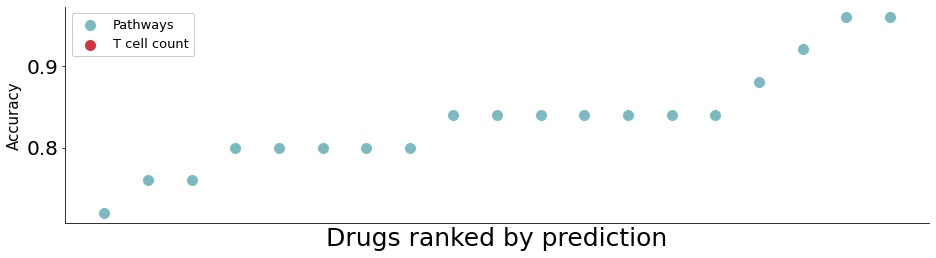

In [488]:
temp = pd.DataFrame({"Pathways":results_text_acc_p, "T cell count":results_text_acc_t})#, "Immunoglobulin levels":results_text_f1_i})


fig = plt.figure(figsize = [12,3])
ax = fig.add_axes([0,0,1,1])

#temp = temp.loc[methods].transpose()
temp = temp.sort_values("Pathways")


colors = ['#7bbac1ff', '#d2323cff', 'green']#, 'yellow']
method_labels = ["Pathways", "T cell count", "Immunoglobulin levels", 'Neutrophil count']
            
handles = []
for c,x in zip(colors,temp.columns):
    h = ax.scatter(range(len(temp.index)), temp[x], c=c, s = 100)
    handles.append(h)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([])
ax.set_xlabel("Drugs ranked by prediction", fontsize = 25)
ax.set_ylabel("Accuracy", fontsize = 15)
if method_labels == None:
    method_labels = [i[0] for i in methods]
ax.legend(handles, method_labels, fontsize = 13, loc = 'upper left', framealpha = 1.0)


#ax.tick_params(axis='x', labelsize=20 )
ax.tick_params(axis='y', labelsize=20 )

In [495]:
#COMPARE NETWORK PROPAGATION AND TEXT BASED MACHINE LEARNING

'''for i in treatment_top:
    print (i)
    print (results_text[i])
    print (results_propagated[i])
    print ()
'''

from matplotlib.pyplot import figure

'''
labels = treatment_top
print (treatment_top)
text = list(results_control_acc.values())
propagated = list(results_propagated_acc.values())
# = list(results_text_acc.values())

x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
rects1 = ax.bar(x - width/2, text, width, label='Pathways(-P)')
rects2 = ax.bar(x + width/2, propagated, width, label='Pathways(+P)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy scores', size = 20)
ax.set_title('Pathways as therapy prediction', size = 30)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical', size = 20)
ax.legend(prop={'size': 15})


fig.tight_layout()

plt.show()

'''

"\nlabels = treatment_top\nprint (treatment_top)\ntext = list(results_control_acc.values())\npropagated = list(results_propagated_acc.values())\n# = list(results_text_acc.values())\n\nx = np.arange(len(labels))\nwidth = 0.3\nfig, ax = plt.subplots()\nfig.set_size_inches(18.5, 10.5)\nrects1 = ax.bar(x - width/2, text, width, label='Pathways(-P)')\nrects2 = ax.bar(x + width/2, propagated, width, label='Pathways(+P)')\n\n# Add some text for labels, title and custom x-axis tick labels, etc.\nax.set_ylabel('Accuracy scores', size = 20)\nax.set_title('Pathways as therapy prediction', size = 30)\nax.set_xticks(x)\nax.set_xticklabels(labels, rotation='vertical', size = 20)\nax.legend(prop={'size': 15})\n\n\nfig.tight_layout()\n\nplt.show()\n\n"

In [494]:
from matplotlib.pyplot import figure

'''
labels = treatment_top
text = list(results_control_f1.values())
propagated = list(results_propagated_f1.values())
#propagated = list(results_propagated_f1.values())

x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
rects1 = ax.bar(x - width/2, text, width, label='Pathways(P)')
rects2 = ax.bar(x + width/2, propagated, width, label='Drugs+Pathways(P)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 scores', size = 20)
ax.set_title('Therapy prediction',size = 30)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical', size = 20)
ax.legend(prop={'size': 15})


fig.tight_layout()

plt.show()


print ('beta = ')'''

"\nlabels = treatment_top\ntext = list(results_control_f1.values())\npropagated = list(results_propagated_f1.values())\n#propagated = list(results_propagated_f1.values())\n\nx = np.arange(len(labels))\nwidth = 0.3\nfig, ax = plt.subplots()\nfig.set_size_inches(18.5, 10.5)\nrects1 = ax.bar(x - width/2, text, width, label='Pathways(P)')\nrects2 = ax.bar(x + width/2, propagated, width, label='Drugs+Pathways(P)')\n\n# Add some text for labels, title and custom x-axis tick labels, etc.\nax.set_ylabel('F1 scores', size = 20)\nax.set_title('Therapy prediction',size = 30)\nax.set_xticks(x)\nax.set_xticklabels(labels, rotation='vertical', size = 20)\nax.legend(prop={'size': 15})\n\n\nfig.tight_layout()\n\nplt.show()\n\n\nprint ('beta = ')"